In [186]:
%load_ext autoreload

import matplotlib.pyplot as plt

def plotit(x,y):
    fig, ax = plt.subplots()
    ax.plot(x,y, 'o')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Controller configuration
-----------------------

Overall configuration is held in a class, Config. A Config object holds the list of linux containers, Corsa switches, simulated sites. The following is used to generate and save the configuration. It explains what the various data types are and being used. Refer to coord.py for more details on each of the objects.

In [151]:
%autoreload 2

from coord import Switch, Container, Site, Config, get_config

# Corsa Switches - rtt to SCinet Denver.
wash_sw = Switch("wash-tb-of-1","192.168.120.41",None,vfc="br2",ofport=11,rtt=38.8)
cern_sw = Switch("cern-272-tb-of-1","192.168.120.36",None,"br2",10,rtt=89.5)
amst_sw = Switch("amst-tb-of-1","192.168.120.35",None,"br1",23,rtt=82.5)
aofa_sw = Switch("aofa-tb-of-1","192.168.120.33",None,"br2",2,rtt=5.3)
denv_sw = Switch("denv-tb-of-1","192.168.120.37",None,"br1",10,rtt=2)
atla_sw = Switch("atla-tb-of-1","192.168.120.34",None,"br1",9,rtt=39.5)
switches=[wash_sw,cern_sw,amst_sw,aofa_sw,denv_sw,atla_sw]

# Linux Containers
wash_dtn = Container("wash-192","192.168.120.192",port="eth1")
cern_dtn = Container("cern-194","192.168.120.194",port="eth1")
amst_dtn = Container("amst-190","192.168.120.190",port="eth1")
aofa_dtn = Container("aofa-191","192.168.120.191",port="eth1")
denv_dtn = Container("denv-201","192.168.120.201",port="eth1")
atla_dtn = Container("atla-200","192.168.120.200",port="eth1")
containers = [wash_dtn,cern_dtn,amst_dtn,aofa_dtn,denv_dtn,atla_dtn]

# Simulated sites
wash = Site(name="wash", switch=wash_sw, container=wash_dtn)
amst = Site(name="amst", switch=amst_sw, container=amst_dtn)
cern = Site(name="cern", switch=cern_sw, container=cern_dtn)
denv = Site(name="denv", switch=denv_sw, container=denv_dtn)
aofa = Site(name="aofa", switch=aofa_sw, container=aofa_dtn)
atla = Site(name="atla", switch=atla_sw, container=atla_dtn)
#scinet = Site(name="scinet", switch=None, container=scinet_dtn)

sites = [wash,amst,cern,denv,aofa,atla]

config =Config(switches=switches,containers=containers,sites=sites)
config.save(config_file="demo.config")

Switches,containers, etc are python objects. There is no access functions to their values. They can directly be accessed:

In [152]:
print wash_sw.ip, wash_sw.vfc, wash_sw.ofport, wash_sw.rtt

192.168.120.41 br2 11 38.8


In [153]:
print config.switches
print config.containers
print config.sites

[wash-tb-of-1, cern-272-tb-of-1, amst-tb-of-1, aofa-tb-of-1, denv-tb-of-1, atla-tb-of-1]
[wash-192, cern-194, amst-190, aofa-191, denv-201, atla-200]
[wash, amst, cern, denv, aofa, atla]


Once the config is written into a file, it can be retrieved later:

In [154]:
new_config = get_config(config_file="demo.config")

In [155]:
new_config.switches

[wash-tb-of-1,
 cern-272-tb-of-1,
 amst-tb-of-1,
 aofa-tb-of-1,
 denv-tb-of-1,
 atla-tb-of-1]

Traffic Generator
----------------

Current testing the default generator in coord.py (one file per source at the time). File size distribution is random and delivery delay (i.e. past min deadline) is exponential.

In [187]:

from coord import SingleFileGen

def get_sources(config):
    sources=[]
    dtns = config.containers
    for dtn in dtns:
        sources.append(dtn.name)
    return sources

sources = get_sources(config)
capacity = 500000 # 500 Mbps
epoch = 5 * 60 # 5 mins
#gen = traffic_gen(sources,capacity,epoch)
buckets=[30*1024,15*1024,10*1024,5*1024,1*1025,512,128]
gen = SingleFileGen(sources,capacity,epoch,buckets)

The following shows for each source the additional delay percentage that is added to the shortest possible time transfer.

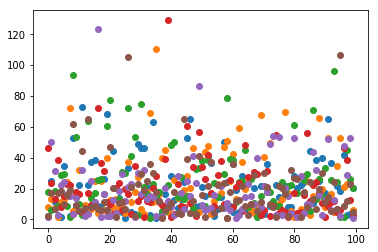

In [188]:
x=[]
y=[]
for i in range(100):
    reqs = gen.generate_requests()
    x.append(i)
    ys = []
    for req in reqs:
        v = ((req.td - req.min_duration) / req.min_duration) * 100
        ys.append(req.td/req.min_duration)
    y.append(ys)
plotit(x,y)